# **Practical Session - Medical image segmentation**


TP5 - DE MENEZES LIMA Marina

# Introduction
The goal of this practical session is to test different segmentation methods seen in the courses on different types of medical images: X-ray scanner (CT) for the segmentation of the kidneys, MRI of the brain for the segmentation of the corpus callosum, temporal sequences of MRI images for the segmentation of the heart (left ventricle for example), dermoscopic images for the segmentation of skin lesions.

You will start by developing a (guided) pipelines to pre-process, identify and segment skin lesions in dermoscopic images. 
Then, you will have to develop a pipeline (not guided) for **AT LEAST** another application (segmentation of the kidneys, corpus callosum or heart).

You will have to write code and comments where you see **XXXXXXXXXXXXXXXXXXXXX**

**Deadline**: You will have to upload a single jupyter notebook .ipynb with your answers (code + text) before the deadline (please check on Ecampus/Moodle). 

**The uploaded file should be named 'TP_Seg_YOURSURNAME.ipynb'.** 

## Skin lesions

A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer (more than 60k deaths in 2015 worldwide). Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (computer-aided diagnosis (CAD) ).

Let's start with downloading some dermoscopic images. You can use the following code and download them from my Google Drive

In [64]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd

  gdd.download_file_from_google_drive(file_id='1BoU4S9xFgKaCtquU03kZQbH3Yv42oU_-',
                                      dest_path='./skinlesion.zip',
                                      unzip=True)  
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
# You should write the absolute path of your working directory with the data
Working_directory="./" 

You can list the content of the folder using the command line *!ls*

In [65]:
data_path = Working_directory + 'skinlesion'
!ls './skinlesion'

IM_000180.jpg		    IM_000833_Segmentation.png
IM_000180_Segmentation.png  ISIC_0000001.jpg
IM_000215.jpg		    ISIC_0000001_Segmentation.png
IM_000215_Segmentation.png  ISIC_0000019.jpg
IM_000407.jpg		    ISIC_0000019_Segmentation.png
IM_000407_Segmentation.png  ISIC_0000042.jpg
IM_000445.jpg		    ISIC_0000042_Segmentation.png
IM_000445_Segmentation.png  ISIC_0000046.jpg
IM_000510.jpg		    ISIC_0000046_Segmentation.png
IM_000510_Segmentation.png  ISIC_0000095.jpg
IM_000613.jpg		    ISIC_0000095_Segmentation.png
IM_000613_Segmentation.png  ISIC_0000146.jpg
IM_000833.jpg		    ISIC_0000146_Segmentation.png


All images are RGB images in format .jpg. You also have the corresponding ground truth (ie manual) segmentation in format .png 

In [24]:
import glob

listImages=glob.glob(data_path + '/*.jpg')
N=len(listImages)
print('There are {} images'.format(N))
print(listImages)

There are 13 images
['./skinlesion/ISIC_0000095.jpg', './skinlesion/ISIC_0000146.jpg', './skinlesion/IM_000215.jpg', './skinlesion/IM_000613.jpg', './skinlesion/IM_000510.jpg', './skinlesion/IM_000180.jpg', './skinlesion/ISIC_0000019.jpg', './skinlesion/ISIC_0000046.jpg', './skinlesion/IM_000445.jpg', './skinlesion/ISIC_0000001.jpg', './skinlesion/IM_000833.jpg', './skinlesion/ISIC_0000042.jpg', './skinlesion/IM_000407.jpg']


Let's plot one image with the corresponding segmentation

im is composed of  uint8  going from  0  to  255
im_Seg is composed of :  uint8  - Max value:  255  - Min value:  0  - Unique values:  [  0   1   2   3   4   5   6   7   8   9  10  11 243 244 245 246 247 248
 249 250 251 252 253 254 255]


Text(0.5, 1.0, 'Image with mask')

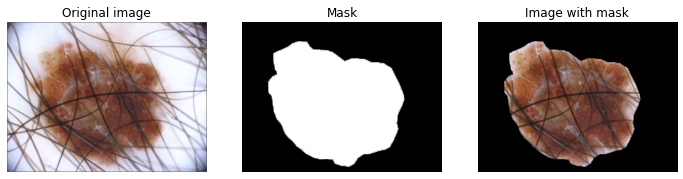

In [38]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

# Choose a figure and plot it with the ground truth segmentation
indexIm=12
filename = listImages[indexIm]
im = imread(filename)
print('im is composed of ', im.dtype, ' going from ', np.min(im), ' to ', np.max(im))
filename_Segmentation = filename[:-4] + '_Segmentation.png'
im_Seg = imread(filename_Segmentation) # Value 0 or 255
print('im_Seg is composed of : ',im_Seg.dtype, ' - Max value: ', np.max(im_Seg), ' - Min value: ', np.min(im_Seg), ' - Unique values: ', np.unique(im_Seg))
im_Seg_bool = im_Seg == 255 
im_Seg_expand = np.expand_dims(im_Seg_bool, axis=2)
im_mul_mask = (im_Seg_expand*im) # pixel-wise product

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(im)
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(im_Seg_bool,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Mask")
grid[2].imshow(im_mul_mask)
grid[2].axis('off')
grid[2].set_title("Image with mask")

First, let's simplify the problem by using only the blue channel and rescaling the figure

Text(0.5, 1.0, 'Rescaled image with rescaled mask')

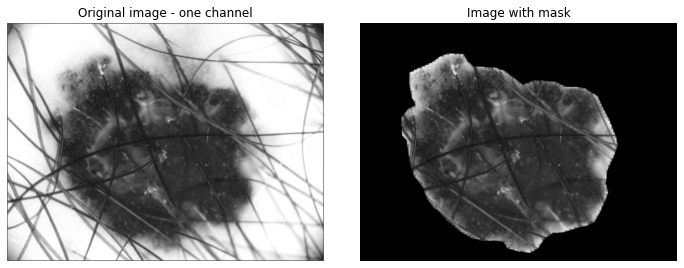

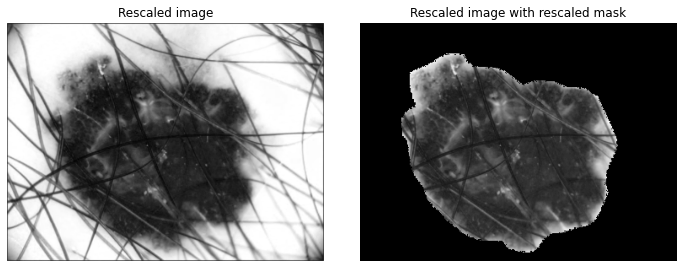

In [39]:
from skimage.transform import rescale
from skimage import img_as_bool

# We only select the blue channel to start
imb=im[:,:,2]

# We rescale to speed up computations
imbr = np.uint8(rescale(imb, 0.25, anti_aliasing=True,  order=1, preserve_range=True))
im_Seg_r =  rescale(im_Seg, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
im_Seg_r_bool = im_Seg_r==255 # binary mask

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 2),
                axes_pad = 0.5)
grid[0].imshow(imb,cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image - one channel")
grid[1].imshow(imb*im_Seg_bool,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Image with mask")

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 2),
                axes_pad = 0.5)
grid[0].imshow(imbr,cmap='gray')
grid[0].axis('off')
grid[0].set_title("Rescaled image")
grid[1].imshow(imbr*im_Seg_r_bool,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Rescaled image with rescaled mask")

Now, let's try to use K-means to directly segment the image. We will use the scikit-learn implementation.

You should choose the number of clusters. Start with 2 and then look what it happens when you increase the number of clusters.

Be careful: Kmeans randomly assigns the labels of the clusters (0,1,2,...,K).

**Question**: You need to propose a method to assign the label 1 to the cluster (or clusters) containing the skin lesion and 0 for the other clusters. Look at the different images and try simple solutions (look at the position of the lesion for instance...). You can use the Dice score, defined as $DSC=\frac{2TP}{2TP+FP+FN}$ for boolean data, to quantitavely compare the reference segmentation with the one you estimate.

The dice similarity is  0.8202995453329767


Text(0.5, 1.0, 'Clustering result')

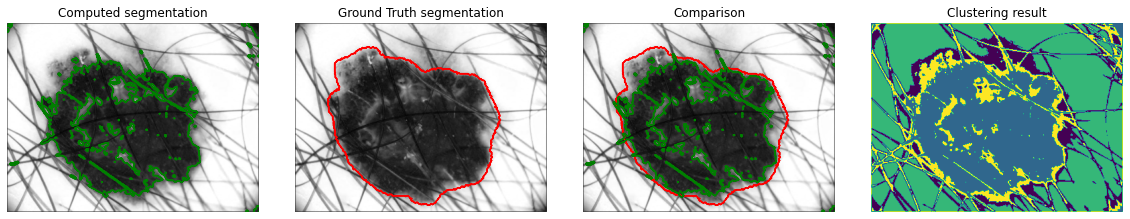

In [40]:
from sklearn.cluster import KMeans
from skimage import morphology
from scipy.spatial.distance import dice

Ncluster = 4

x, y = imbr.shape
imFloat = np.array(imbr, dtype=np.float64) / 255 # transform into float for computational reason
kmeans = KMeans(n_clusters=Ncluster) # use K-means algorithm 
kmeansSeg = kmeans.fit_predict(imFloat.reshape(-1,1)) # fit to the data reshaped as a 1D vector
kmeansSeg = np.reshape(kmeansSeg,(x,y)) # reshape as the initial image
# print(np.unique(kmeansSeg))

# plt.figure()
# plt.hist(kmeansSeg.reshape(-1,1))
# plt.title('Histogram of estimated labels')

index_lesion=1
kmeansSeg_bool = kmeansSeg==index_lesion

print('The dice similarity is ', 1-dice(kmeansSeg_bool.flatten(),im_Seg_r_bool.flatten()))


fig = plt.figure(figsize=(20, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 4),
                axes_pad = 0.5)
grid[0].imshow(imbr,cmap='gray')
grid[0].contour(morphology.opening(kmeansSeg_bool, morphology.disk(1)), colors='green', linewidths=1)
grid[0].axis('off')
grid[0].set_title("Computed segmentation")
grid[1].imshow(imbr,cmap='gray')
grid[1].contour(morphology.opening(im_Seg_r_bool, morphology.disk(1)), colors='red', linewidths=1)
grid[1].axis('off')
grid[1].set_title("Ground Truth segmentation")
grid[2].imshow(imbr,cmap='gray')
grid[2].contour(morphology.opening(im_Seg_r_bool, morphology.disk(1)), colors='red', linewidths=1)
grid[2].contour(morphology.opening(kmeansSeg_bool, morphology.disk(1)), colors='green', linewidths=1)
grid[2].axis('off')
grid[2].set_title("Comparison")
grid[3].imshow(kmeansSeg)
grid[3].axis('off')
grid[3].set_title("Clustering result")


# Mathematical Morphology

You could also use the morphological operators seen during the previous lectures to segment the skin lesions. First, we will remind you some morphological operators that you could use to segment the lesion. Please note that the structural elements and the hyper-parameters have been randomly chosen... you should probably change them.

**Question**: Propose a pipeline using morphological operators to segment the skin lesions and motivate your choices.

In [41]:
import skimage.morphology as morpho  

def strel(forme,taille,angle=45):
    """renvoie un element structurant de forme  
     'diamond'  boule de la norme 1 fermee de rayon taille
     'disk'     boule de la norme 2 fermee de rayon taille
     'square'   carre de cote taille (il vaut mieux utiliser taille=impair)
     'line'     segment de langueur taille et d'orientation angle (entre 0 et 180 en degres)
      (Cette fonction n'est pas standard dans python)
    """

    if forme == 'diamond':
        return morpho.selem.diamond(taille)
    if forme == 'disk':
        return morpho.selem.disk(taille)
    if forme == 'square':
        return morpho.selem.square(taille)
    if forme == 'line':
        angle=int(-np.round(angle))
        angle=angle%180
        angle=np.float32(angle)/180.0*np.pi
        x=int(np.round(np.cos(angle)*taille))
        y=int(np.round(np.sin(angle)*taille))
        if x**2+y**2 == 0:
            if abs(np.cos(angle))>abs(np.sin(angle)):
                x=int(np.sign(np.cos(angle)))
                y=0
            else:
                y=int(np.sign(np.sin(angle)))
                x=0
        rr,cc=morpho.selem.draw.line(0,0,y,x)
        rr=rr-rr.min()
        cc=cc-cc.min()
        img=np.zeros((rr.max()+1,cc.max()+1) )
        img[rr,cc]=1
        return img
    raise RuntimeError('Erreur dans fonction strel: forme incomprise')

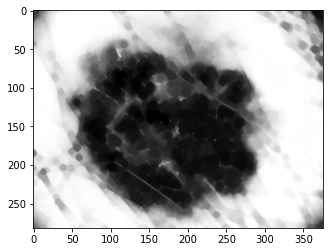

In [42]:
#fermeture par un disque
sizeDisque=4
disk=strel('disk',sizeDisque)
closeDisk=morpho.closing(imbr,disk)

plt.figure()
plt.imshow(closeDisk,cmap='gray')
plt.show()

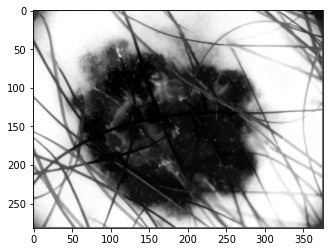

In [43]:
# Reconstruction par erosion
RecEr=np.max(imbr) - morpho.reconstruction(np.max(imbr)-closeDisk,np.max(imbr)-imbr)
plt.figure()
plt.imshow(RecEr,cmap='gray')
plt.show()


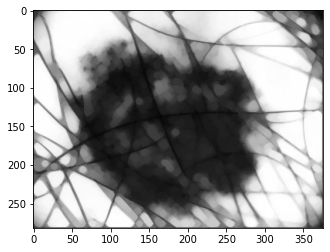

In [44]:
# Overture (remove small bright parts)
se=strel('disk',4)
Open=morpho.opening(imbr,se)

plt.figure()
plt.imshow(Open,cmap='gray')
plt.show()

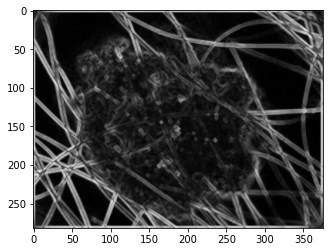

In [45]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed 
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.morphology import disk

#gradient morphologique de l'image initiale
se=morpho.selem.disk(2)
grad=morpho.dilation(imbr,se)-morpho.erosion(imbr,se)

plt.figure()
plt.imshow(grad,cmap='gray')
plt.show()



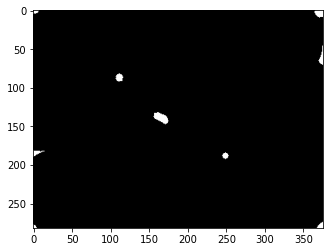

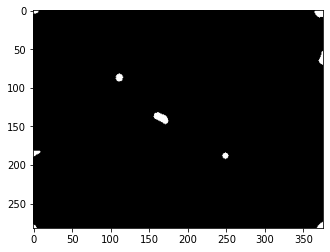

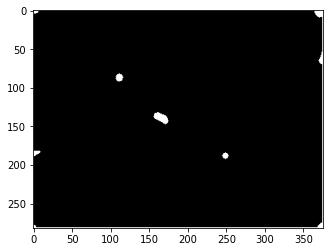

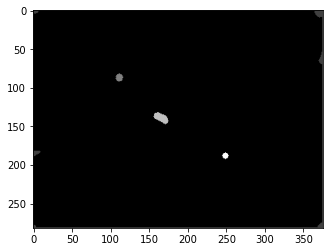

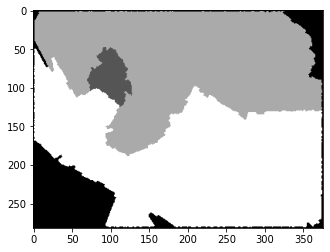

4


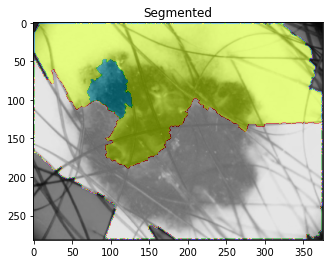

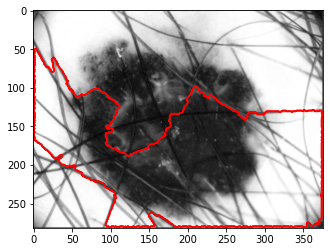

The dice similarity is  0.5472513629156621


In [46]:
# Overture (remove small bright parts)
se=strel('disk',40)
Open=morpho.opening(closeDisk,se)

# Minima regionaux
maxIm=255
temp=Open.copy()
    
for i in range(Open.shape[0]):
    for j in range(Open.shape[1]):
        if Open[i,j] < maxIm: 
            temp[i,j]=Open[i,j]+1
reco=maxIm-morpho.reconstruction(maxIm-temp,maxIm-Open)
minReg=np.uint8(reco)-Open

plt.figure()
plt.imshow(minReg,cmap='gray')
plt.show()

#suppression des marqueurs trop petits
tailleMin=1
seM=strel('disk',tailleMin)
minReg=morpho.opening(minReg,seM)

plt.figure()
plt.imshow(minReg,cmap='gray')
plt.show()

#ajout d'un marqueur sur le bord de l'image
for i in range(minReg.shape[0]):
    minReg[i,0]=1
    minReg[i,minReg.shape[1]-1]=1
for j in range(minReg.shape[1]):
    minReg[0,j]=1
    minReg[minReg.shape[0]-1,j]=1
    
plt.figure()
plt.imshow(minReg,cmap='gray')
plt.show()

#Any non-zero values in input are counted as features and zero values are considered the background.
markers = ndi.label(minReg)[0]

plt.figure()
plt.imshow(markers,cmap='gray')
plt.show()

# We use the watershed algorithm to compute the labels
labels = watershed(grad, markers)

plt.figure()
plt.imshow(labels,cmap='gray')
plt.show()

plt.figure()
plt.imshow(imbr, cmap=plt.cm.gray)
plt.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.5)
plt.title("Segmented")

#%% visualiation du resultat
values, counts = np.unique(labels, return_counts=True)
print(values[np.argmax(counts)])
segm=labels.copy()
# Choose the greatest area
index=values[np.argmax(counts)]
segm=segm==index
#NB: ce resultat peut servir d'initialisation pour une autre methode de segmentation (croissance de regions, segmentation markovienne, etc.)

#superposition des contours de la segmentation a l'image initiale
plt.figure()
plt.imshow(imbr,cmap='gray')
plt.contour(morphology.opening(segm, morphology.disk(1)), colors='red', linewidths=1)
plt.show()       

print('The dice similarity is ', 1-dice(segm.flatten(),im_Seg_r_bool.flatten()))



We could also use the values of the morphological gradient to find the markers

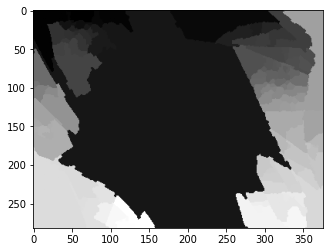

12


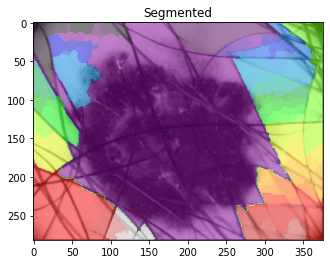

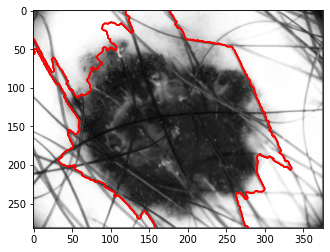

The dice similarity is  0.8501285900181358


In [47]:
markers = grad < 1
markers = ndi.label(markers)[0]

labels = watershed(grad, markers)

plt.figure()
plt.imshow(labels,cmap='gray')
plt.show()

plt.figure()
plt.imshow(imbr, cmap=plt.cm.gray)
plt.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.5)
plt.title("Segmented")

#%% visualiation du resultat
values, counts = np.unique(labels, return_counts=True)
print(values[np.argmax(counts)])
segm=labels.copy()
# Choose the greatest area
index=values[np.argmax(counts)]
segm=segm==index
#NB: ce resultat peut servir d'initialisation pour une autre methode de segmentation (croissance de regions, segmentation markovienne, etc.)

#superposition des contours de la segmentation a l'image initiale
plt.figure()
plt.imshow(imbr,cmap='gray')
plt.contour(morphology.opening(segm, morphology.disk(1)), colors='red', linewidths=1)
plt.show()       

print('The dice similarity is ', 1-dice(segm.flatten(),im_Seg_r_bool.flatten()))

## Otsu's algorithm

Otsu's method looks for a threshold to split a gray-level image into two separate regions, based on their grey-level values. Since the maximum number of grey-levels is finite (and small, 256), we can use an exhaustive search.

The grey-level threshold is the one that minimises the intra-class intensity variance, defined as a weighted sum of the variances of the two regions :

$argmin_{\tau}  \omega_0(\tau)\sigma_0^2(\tau) + \omega_1(\tau)\sigma_1^2(t)$

where

- $\sigma_0^2(\tau)$ and $\sigma_1^2(\tau)$ are the intensity variances of the pixels in the first and second regions
- $\omega_0(\tau)$ and $\omega_1(\tau)$ are the weights of the first and second regions 

Given the histogram of the image with $L$ bins where each bin $i$ has $p(i)$ pixels, we define the weights $\omega_0(\tau)$ and $\omega_1(\tau)$ as:

- $\omega_0(\tau) = \sum_{i=0}^{\tau -1} p(i)$
- $\omega_1(\tau) = \sum_{i = \tau}^{L-1} p(i)$


**Question**: Implement this algorithm in a function called ``segmentation_otsu``. Note : only analyse thresholds which produce two distinct regions. Furthemore, remember that the image has only 256 discrete values. Choose the threshold values accordingly.

In [48]:
def segmentation_otsu(img):

    min_sigma = np.float('inf')
    tau_out = 0
    min_level = 0.0
    max_level = 255.0
    n_levels = 256
    for tau in np.linspace(min_level, max_level,n_levels):
        # first, get weights of the two regions
        omega_0 = np.sum(img < tau)
        omega_1 = np.sum(img >= tau)

        # only analyse thresholds which give two non-empty regions
        if (omega_0 != 0) and (omega_1 != 0):
            sigma_0 = np.var(img[img < tau])
            sigma_1 = np.var(img[img >= tau])

            sigma_total = sigma_0*omega_0 + sigma_1*omega_1

            if (sigma_total < min_sigma):
                tau_out = tau
                min_sigma = sigma_total

    img_out = np.zeros((img.shape[0],img.shape[1]))
    img_out[img<tau_out] = 1
    return img_out,tau_out

You can apply the Otsu method to segment previously pre-processed images.

The best threshold is 150.0
The dice similarity is  0.8762625431814444


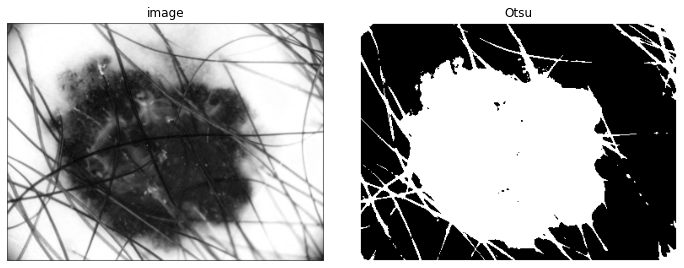

In [49]:
Otsu,tau = segmentation_otsu(imbr)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 2),
                axes_pad = 0.5)
grid[0].imshow(imbr,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(Otsu,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Otsu")

print('The best threshold is {}'.format(tau))
print('The dice similarity is ', 1-dice(Otsu.flatten(),im_Seg_r_bool.flatten()))


One of the problem of the Otsu method it's that there is no notion of connectivity (two regions far away can be in the same region). For such a notion, we turn to region merging.

## Region merging

The region merging algorithm is quite simple : we start with a small region, and add pixels progressively to the region, according to a criterion. We choose the following criterion :

- A pixel $p$ is added to the region if the absolute difference between the pixel value and the region's average value is less than a threshold value (which you must set).

First, we can create a function called ``initialize_segmentation`` which initialises the segmentation with a small circular region centred on a given seed point (the seed point is an input). For this, the following function :

- scipy.ndimage.morphology.distance_transform_edt

can be useful.

In [50]:
from scipy.ndimage.morphology import distance_transform_edt

def initialize_segmentation(seed_pt,img_shape):
    seg_init = np.zeros(img_shape).astype(float)
    seg_init[ seed_pt[0], seed_pt[1]] = 1
    dist = distance_transform_edt(np.abs(1-seg_init))

    # initialise the seeded region with a certain radius
    size_radius = 5
    seg_init = dist < size_radius
    return seg_init

Now, we can create a function called ``segmentation_region_growing`` which carries out the region growing algorithm, with the criterion above, and which uses the ``initialize_segmentation`` function. Again, the functions from ``scipy.ndimage.morphology`` can be useful here.

In [51]:
from scipy.ndimage import binary_dilation

def segmentation_region_growing(img,seed_pt,tau, diskSize):

    # define the neighbourhood (for instance 4-connected pixels)
    nbhood = np.asarray( [ [0,1,0],[1,1,1],[0,1,0]] )

    seg_init = initialize_segmentation(seed_pt,img.shape)
    seg_n_plus_1 = seg_init
    seg_n = np.zeros(seg_n_plus_1.shape)

    # loop while the region can still keep growing
    while( np.abs(seg_n_plus_1 != seg_n).sum() != 0):
        seg_n = seg_n_plus_1
        seg_n_plus_1 = binary_dilation(seg_n, structure=nbhood).astype(seg_n.dtype)
        # calculate average value
        avg = np.sum( img[seg_n>0] ) / ( float(seg_n.sum()))
        seg_n_plus_1 = np.logical_and( seg_n_plus_1 , np.abs( img-avg ) < tau)
        # do not lose previous points of the segmentation
        seg_n_plus_1 = np.logical_or( seg_n_plus_1 , seg_n)

    disk = strel('disk', diskSize)
    seg_n = morpho.closing(seg_n,disk)

    return seg_n,seg_init

**Question**: Carry out the segmentation on the skin lesion images with the seed point and threshold specified in the following code. The proposed implementation is very simple. We could definitely improve it. Do you see how ? You can simply explain how you would do it or, if you have time, even try to implement it. 

To improve the implemantation we can try applying a closing morphological operator. That way, lighter areas in the lesion that could interfere on the segmentation (depending on the threshold) will be eliminated and the results will present a bigger dice similarity.

The dice similarity is  0.9178798656148858


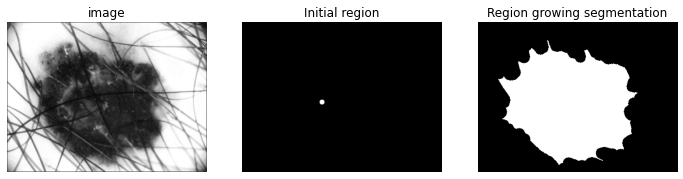

In [52]:
seed_pt = (150,150)
tau = 40
img_out_region_growing,seg_init = segmentation_region_growing(imbr,seed_pt,tau, 10)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(imbr,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(seg_init,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Initial region")
grid[2].imshow(img_out_region_growing,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Region growing segmentation")

print('The dice similarity is ', 1-dice(img_out_region_growing.flatten(),im_Seg_r_bool.flatten()))


# Graph-Cut
You can also use graph-cut, as seen in the previous lecture, to segment the image or to remove hair. You could, for instance, see the hair as noise and try to remove it using the gaussian model or the one of Potts.

Here, you can find an example of binary segmentation.

**Question**: propose a pipeline, based on graph-cuts and other pre-processing or post-processing methods, to correctly segment the images.

In [53]:
!pip install PyMaxflow
import maxflow

     |████████████████████████████████| 123 kB 5.2 MB/s 
  Created wheel for PyMaxflow: filename=PyMaxflow-1.2.13-cp37-cp37m-linux_x86_64.whl size=528315 sha256=6b2139e298122176ac028b30aa905e5bf0066dcf5e1d54d3d81d9c32ffdabd1f
  Stored in directory: /root/.cache/pip/wheels/62/f9/eb/62e4c1fcbee43e64b749674879fd3248d8c49f08c37c8a564d
Successfully built PyMaxflow


In [54]:
from bokeh.plotting import figure, output_file, show
from bokeh.plotting import show as showbokeh
from bokeh.io import output_notebook
output_notebook()

def affiche_pour_colab(im,MINI=None, MAXI=None,titre=''): #special colab, don't look
  def normalise_image_pour_bokeh(X,MINI,MAXI):
    if MAXI==None:
      MAXI = np.max(X)
    if MINI==None:
      MINI = np.min(X)
    imt=np.copy(X.copy())
    imt=(np.clip(imt,MINI,MAXI)/(MAXI-MINI))
    imt[imt<0]=0
    imt[imt>1]=1
    imt*=255
    sortie=np.empty((*imt.shape,4),dtype=np.uint8)
    for k in range(3):
      sortie[:,:,k]=imt
    sortie[:,:,3]=255
    return sortie

  img = im
  img=normalise_image_pour_bokeh(np.flipud(im),MINI,MAXI)
  p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")], y_range=[im.shape[0], 0], x_range=[0, im.shape[1]])
  # p.x_range.range_padding = p.y_range.range_padding = 0
  # must give a vector of images
  p.image(image=[np.flipud(im)], x=0, y=im.shape[0], dw=im.shape[1], dh=im.shape[0], palette="Greys9", level="image")
  p.xgrid.visible = False
  p.ygrid.visible = False
  showbokeh(p)

def affiche(im,MINI=0.0, MAXI=None,titre='',printname=False):
  affiche_pour_colab(im,MINI=MINI, MAXI=MAXI,titre=titre)

In [55]:
affiche(imbr)

The dice similarity is  0.9425650952527088


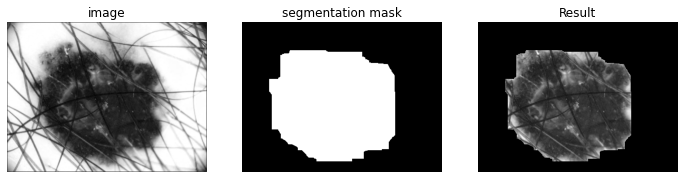

In [56]:
beta = 300000

crop_classe1 = imbr[190:230,125:140]
m1 = np.mean(crop_classe1)

crop_classe2 = imbr[245:265,290:330]
m2 = np.mean(crop_classe2)


## Graph cut binaire

g = maxflow.Graph[float]()
nodeids = g.add_grid_nodes(imbr.shape)
g.add_grid_edges(nodeids, beta)
g.add_grid_tedges(nodeids, (imbr-m1)**2, (m2-imbr)**2)
flow = g.maxflow()
sgm = g.get_grid_segments(nodeids)
im_bin = 1 - np.int_(np.logical_not(sgm))

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(imbr,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(im_bin,cmap='gray')
grid[1].axis('off')
grid[1].set_title("segmentation mask")
grid[2].imshow(imbr*im_bin,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Result")

print('The dice similarity is ', 1-dice(im_bin.flatten(),im_Seg_r_bool.flatten()))


---

# SECOND PART

---

**Question** Please develop a segmentation pipeline using a combination of the previous methods (or others) for at least one of the following applications.

# Brain MRI

Here you can select medial slices of the brain of 4 different subjects. You also have manual segmentations of the corpus callosum.

In [60]:

if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd

  gdd.download_file_from_google_drive(file_id='1UTSW2nGWV8SBE_ILZQkM-jQvnfoQKDlm',
                                      dest_path='./brainMRI.zip',
                                      unzip=True)   

In [61]:
brainMRI_path = Working_directory + 'brainMRI'
!ls './brainMRI'

listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')
print('There are', len(listImagesbrainMRI),  'brain MRI images')
print(listImagesbrainMRI)

MRIs1.png      MRIs2.png      MRIs3.png      MRIs4.png
MRIs1-seg.png  MRIs2-seg.png  MRIs3-seg.png  MRIs4-seg.png
There are 4 brain MRI images
['./brainMRI/MRIs2-seg.png', './brainMRI/MRIs3-seg.png', './brainMRI/MRIs4-seg.png', './brainMRI/MRIs1-seg.png']


./brainMRI/MRIs1-seg.png
Reading image  ./brainMRI/MRIs1.png


Text(0.5, 1.0, 'Image with segmentation\n corpus callosum')

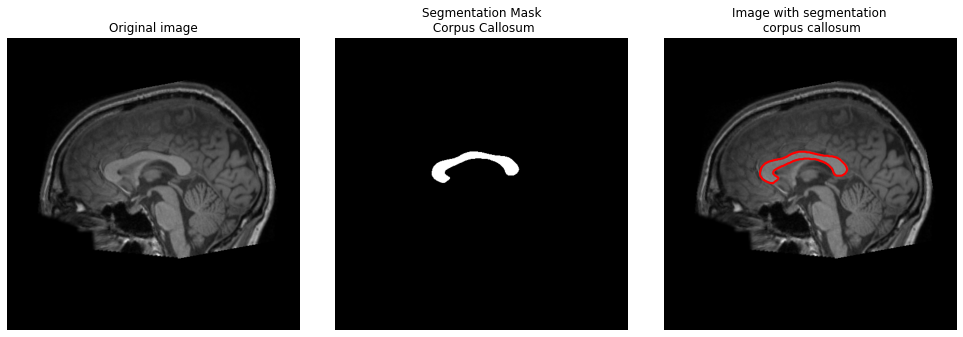

In [66]:
from skimage.measure import find_contours

# Choose a figure and plot it with the ground truth segmentation
indexIm=3 # between 0 and 3

# Brain MRI
filename_Segmentation = listImagesbrainMRI[indexIm]
print(filename_Segmentation)
im_Seg = imread(filename_Segmentation)
filename = filename_Segmentation[:-8] + '.png'
imG = imread(filename) 

print('Reading image ', filename)

if imG.shape != im_Seg.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Im Seg we have masks of the corpus callosum
maskCC=im_Seg==255
contourMask = find_contours(maskCC, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(imG, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(maskCC,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask\n Corpus Callosum")
grid[2].imshow(imG, cmap='gray')
for contour in contourMask:
  grid[2].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[2].axis('off')
grid[2].set_title("Image with segmentation\n corpus callosum")


For this case, we can apply the Region Growing method, obtaining a very good result with dice similarity of 0.93.

The dice similarity is  0.9339879978177851


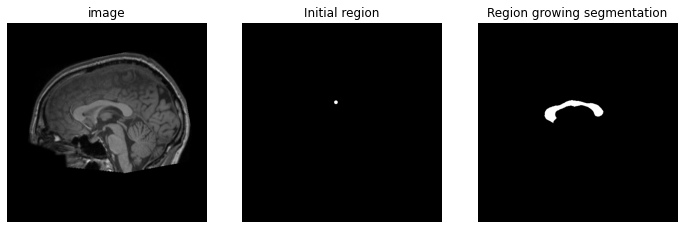

In [67]:
seed_pt = (205, 240)
tau = 12
img_out_region_growing, seg_init = segmentation_region_growing(imG,seed_pt,tau, 10)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(imG,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(seg_init,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Initial region")
grid[2].imshow(img_out_region_growing,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Region growing segmentation")

print('The dice similarity is ', 1-dice(img_out_region_growing.flatten(),maskCC.flatten()))

# MRI heart

The last section is about MRI sequences of the heart. Your goal is to segment the left ventricule. Be careful, the segmentation is not a maks but a series of points (landmarks). To obtain a binary mask, you should first interpolate the points (using for instance a spline).


In [68]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd

  gdd.download_file_from_google_drive(file_id='1BZtShVk7LVG032GOlcLs0K4Eaj6gnBed',
                                      dest_path='./MRIheart.zip',
                                      unzip=True)    

In [69]:
from scipy.io import loadmat


MRIheart_path = Working_directory + 'MRIheart/'
!ls './MRIheart'

data=loadmat(MRIheart_path + 'dataMRIheart.mat')
data=data['data']
seg=loadmat(MRIheart_path + 'segMRIheart.mat')
seg=seg['seg']

print('MRI volume of the heart composed of', data.shape[2], 'slices along the z axis and', data.shape[3], 
'temporal frames. Each slice is an image ', data.shape[0], ' x ',  data.shape[1])
print('For each slice and at each time frame we have a manual segmentation composed of',seg[4,4].shape[0] , '2D landmarks')

print('Be careful, some slices do not have the left ventricle and the manual segmentation is not simply empty but it contains the value:', seg[0,0] )

dataMRIheart.mat  segMRIheart.mat
MRI volume of the heart composed of 11 slices along the z axis and 20 temporal frames. Each slice is an image  256  x  256
For each slice and at each time frame we have a manual segmentation composed of 65 2D landmarks
Be careful, some slices do not have the left ventricle and the manual segmentation is not simply empty but it contains the value: [[-99999]]


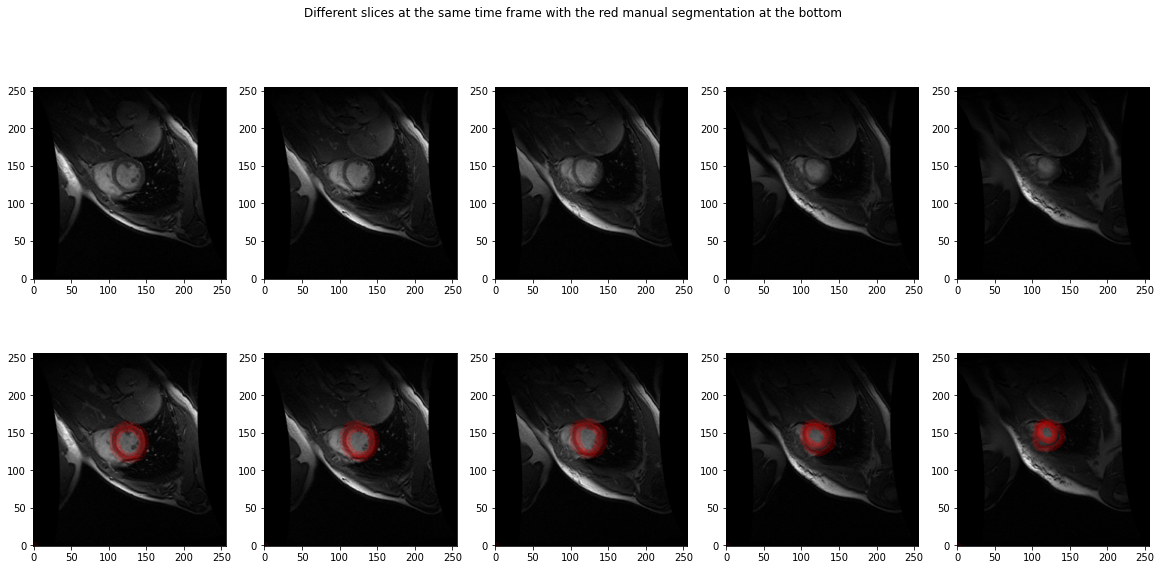

In [70]:
plt.figure(figsize=(20, 9))
plt.suptitle('Different slices at the same time frame with the red manual segmentation at the bottom')
plt.subplot(2, 5, 1)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 2)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 3)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 4)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 5)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 6)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[4,1][:,0], seg[4,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 7)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[5,1][:,0], seg[5,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 8)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[6,1][:,0], seg[6,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 9)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[7,1][:,0], seg[7,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 10)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[8,1][:,0], seg[8,1][:,1], c='r',alpha=0.1) 

This time, we are going to apply the Region Growing method, a dilation  and then a closure to fill and widen the recovered area.

We can see that his method manages to locate globally where the ventricle is but does not manage to make its perfect contour.

As the image collection is similar in terms of size and scale, a change of parameters is not necessary when analysing each image.

(-0.5, 255.5, 255.5, -0.5)

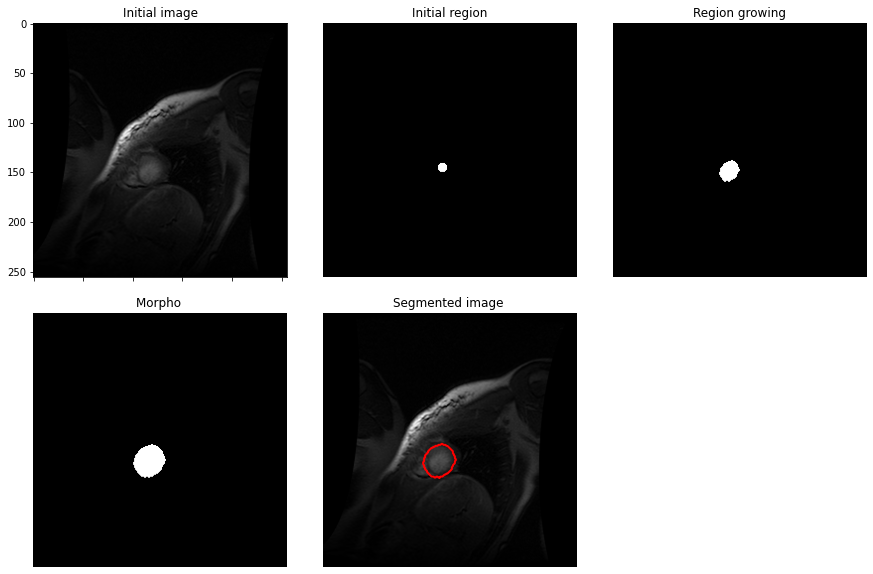

In [76]:
im=data[:,:,8,1]

#Region growing
seed_pt = (145,120)
tau = 70
img_out_region_growing, seg_init = segmentation_region_growing(im, seed_pt, tau, 10)

#Morpho
se = strel('disk',6)
dilation = morpho.dilation(img_out_region_growing, se)
closing = morpho.closing(dilation, se)

maskheart = closing == 1
contourMask = find_contours(maskheart, 0.5)

fig = plt.figure(figsize=(15, 10))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)

grid[0].imshow(im,cmap='gray')
grid[0].set_title("Initial image")

grid[1].imshow(seg_init,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Initial region")

grid[2].imshow(img_out_region_growing,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Region growing")

grid[3].imshow(maskheart,cmap='gray')
grid[3].axis('off')
grid[3].set_title("Morpho ")
grid[4].imshow(im, cmap='gray')
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[4].axis('off')
grid[4].set_title("Segmented image ")

grid[5].axis('off')